<a href="https://colab.research.google.com/github/1900690/koukai/blob/main/mite_demo_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@title 事前準備 { display-mode: "form" }
import shutil
import os
%cd -q '/content/'
# Download trained weights
!wget -q https://github.com/1900690/koukai/releases/download/mite_demo/mite_detect_2.zip
shutil.unpack_archive('/content/mite_detect_2.zip', '/content')
os.remove('/content/mite_detect_2.zip')

In [2]:
#@title 画像のアップロード { display-mode: "form" }
検証用画像のアップロード方法を選択してください= "\u691C\u51FA\u7528\u753B\u50CF\u3092\u30A2\u30C3\u30D7\u30ED\u30FC\u30C9" #@param ["サンプル画像で検出", "検出用画像をアップロード", "カメラで画像を撮影"]

import os
import datetime
dt_now = datetime.datetime.now()
#カメラ用関数定義
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename


if 検証用画像のアップロード方法を選択してください== "\u691C\u51FA\u7528\u753B\u50CF\u3092\u30A2\u30C3\u30D7\u30ED\u30FC\u30C9" :
  if os.path.exists('/content/originals_test'):
    shutil.rmtree('/content/originals_test')

  if not os.path.exists('/content/originals_test/'):
      os.makedirs('/content/originals_test/')

  %cd -q '/content/originals_test/'

  from google.colab import files
  uploaded = files.upload()

elif 検証用画像のアップロード方法を選択してください== "\u30B5\u30F3\u30D7\u30EB\u753B\u50CF\u3067\u691C\u51FA":
    if os.path.exists('/content/originals_test'):
      shutil.rmtree('/content/originals_test')

    if not os.path.exists('/content/originals_test/'):
      os.makedirs('/content/originals_test/')
    
    shutil.copy('/content/mite_detect_1/yolov7/figure/demo_img.jpg','/content/originals_test/demo_img.jpg')
else:
    #if os.path.exists('/content/originals_test'):
    #  shutil.rmtree('/content/originals_test')

    if not os.path.exists('/content/originals_test/'):
      os.makedirs('/content/originals_test/')
    
    %cd -q '/content'

    from IPython.display import Image
    try:
      filename = take_photo()
      title=dt_now.strftime('%Y%m%d_%H%M%S_000')

      #print('Saved to {}'.format(title+".jpg"))
      
      # Show the image which was just taken.
      #display(Image(filename))
    except Exception as err:
      # Errors will be thrown if the user does not have a webcam or if they do not
      # grant the page permission to access it.
      print(str(err))

    shutil.move('/content/photo.jpg', '/content/originals_test/'+title+".jpg")

Saving IMG_20220310_110900_000.jpg to IMG_20220310_110900_000.jpg
Saving IMG_20220310_111004_000.jpg to IMG_20220310_111004_000.jpg
Saving IMG_20220310_111048_000.jpg to IMG_20220310_111048_000.jpg


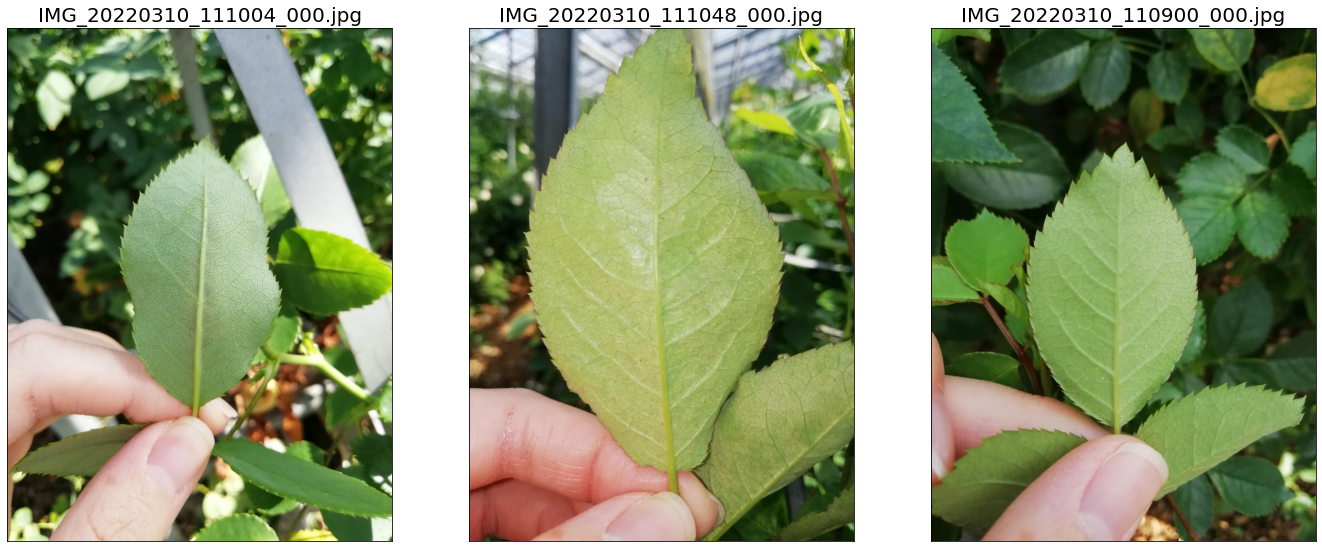

In [7]:
#@title 検出器にかける画像を表示します { display-mode: "form" }

import cv2
from glob import glob
import matplotlib.pyplot as plt
import os

def show_images_glob(images, figsize=(40,20), columns = 5):
  plt.figure(figsize=figsize)
  for i, image in enumerate(images):
      plt.subplot(len(images) / columns + 1, columns, i + 1)
      plt.title(image[24:], loc='center',fontsize=20)
      plt.tick_params(labelbottom=False, labelleft=False, labelright=False, labeltop=False,bottom=False, left=False, right=False, top=False)
      plt.imshow(cv2.cvtColor(cv2.imread(image),cv2.COLOR_BGR2RGB))

SOURCE_IMAGES = "/content/originals_test"
FILE_PATTERN = "*.jpg" #ワイルドカードでフィルタリング
images = glob(os.path.join(SOURCE_IMAGES, FILE_PATTERN))

show_images_glob(images)

Namespace(agnostic_nms=False, augment=False, classes=None, conf_thres=0.42, device='', exist_ok=False, img_size=640, iou_thres=0.45, name='/content/detect_output', no_trace=False, nosave=False, project='runs/detect', save_conf=True, save_txt=True, source='/content/originals_upsamples', update=False, view_img=False, weights=['/content/mite_detect_1/yolov7/weights/best.pt'])
/usr/local/lib/python3.8/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
Done. (43.928s)


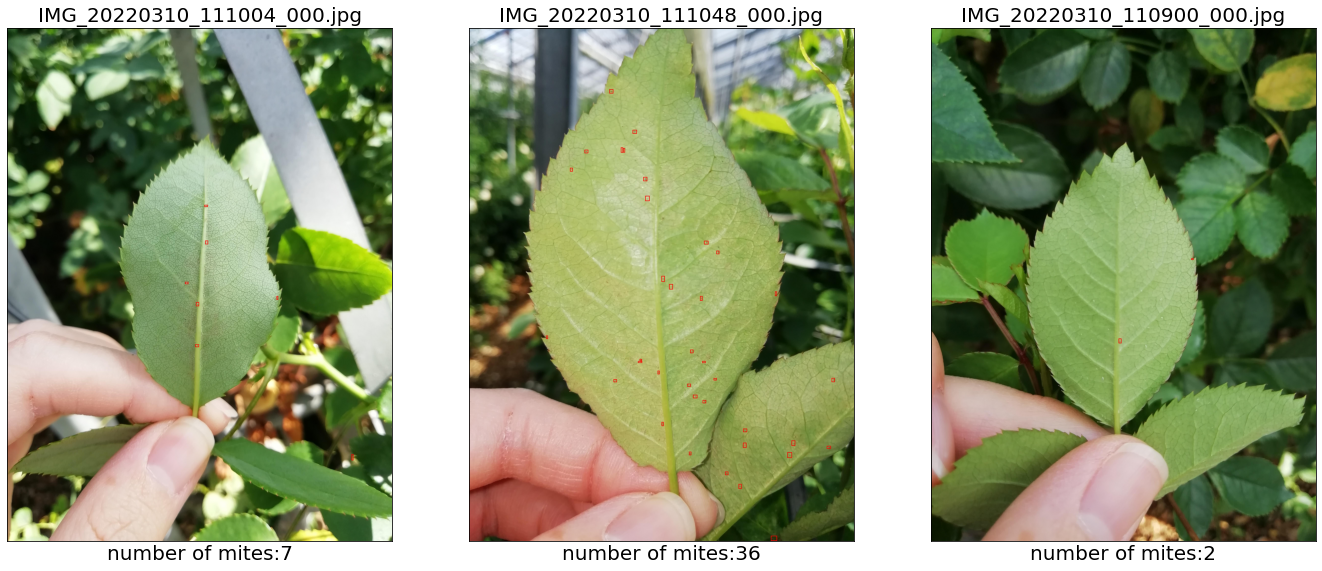

In [12]:
#@title 検出を行う { display-mode: "form" }
split_x=20
split_y=20

import cv2
import numpy as np
import os
import shutil

if not os.path.exists('/content/originals_test'):
  shutil.unpack_archive('/content/originals_test.zip', '/content')

#'NoneType' object is not subscriptableといわれるので先にipynb_checkpointsを消す
!rm -rf `find -type d -name .ipynb_checkpoints`

#画像の読み込み
read_files_name='/content/originals_test/'
read_files = os.listdir(read_files_name)

for file_name in read_files:
  fname = read_files_name+file_name #画像ファイル名
  foldaname=fname[9:]


  #img = np.array(Image.open(fname))  
  img=cv2.imread(fname,cv2.IMREAD_COLOR)
  #画像分割先のフォルダを作成
  if not os.path.exists('/content/split_pic_original/'+file_name[:-4]):
    os.makedirs('/content/split_pic_original/'+file_name[:-4])


  #画像の読み込み
  h,w=img.shape[:2]

  #画像の分割処理
  cx=0
  cy=0
  for j in range(split_x):
      for i in range(split_y):
          split_pic=img[cy:cy+int(h/split_y),cx:cx+int(w/split_x),:]          
          cv2.imwrite("/content/split_pic_original/"+file_name[:-4]+"/"+file_name[:-4]+'_y'+str('{0:02d}'.format(int(i)))+'_x'+str('{0:02d}'.format(int(j)))+foldaname[-4:],split_pic)
          cy=cy+int(h/split_y)
      cy=0
      cx=cx+int(w/split_x)

  #分割する線を描いた画像を出力
  y_step=int(h/split_y) #縦の分割間隔
  x_step=int(w/split_x) #横の分割間隔

  #オブジェクトimgのshapeメソッドの1つ目の戻り値(画像の高さ)をimg_yに、2つ目の戻り値(画像の幅)をimg_xに
  #img_y,img_x=img.size
  img_y,img_x=img.shape[:2]  

  #横線を引く：y_stepからimg_yの手前までy_stepおきに白い(BGRすべて255)横線を引く
  img[y_step:img_y:y_step, :, :] = 0
  #縦線を引く：x_stepからimg_xの手前までx_stepおきに白い(BGRすべて255)縦線を引く
  img[:, x_step:img_x:x_step, :] = 0

  cv2.imwrite("/content/split_pic_original/"+file_name[:-4]+"grid"+foldaname[-4:],img) #ファイル名'grid.png'でimgを保存
#★★★★★★★★★★
import glob
if not os.path.exists('/content/originals_grid/'):
    os.makedirs('/content/originals_grid/')

originals=('/content/split_pic_original/*.jpg')
read_files = glob.glob(originals)

for i in read_files:
  shutil.copy(i, '/content/originals_grid/')
#★★★★★★★★★★
#画像サイズを640にアップサンプリング
import cv2
import glob
import os

if not os.path.exists('/content/originals_upsamples/'):
  os.makedirs('/content/originals_upsamples/')

read_folda_name='/content/split_pic_original/'
read_folda = os.listdir(read_folda_name)

for image_folda_name in read_folda:
  originals=('/content/split_pic_original/'+image_folda_name+'/*')
  read_files = glob.glob(originals)

  for imgpass in read_files:
    # 読み込む画像を選択
    img = cv2.imread(imgpass)
    h,w=img.shape[:2]
    # サイズ設定｜cv2では(幅、高さ）の順で数値を設定
    size = (w*5,h*5) 
    # 画像拡大・縮小 オプションで拡大計算式変更可能
    img_inter_area  = cv2.resize(img,size,interpolation = cv2.INTER_LINEAR) 
    #保存
    cv2.imwrite('/content/originals_upsamples/'+os.path.split(imgpass)[1], img_inter_area)

#★★★★★★★★★★
#検出

if os.path.exists('/content/detect_output'):
  shutil.rmtree('/content/detect_output')

%cd -q '/content/mite_detect_1/yolov7'
!python detect.py \
  --weights /content/mite_detect_1/yolov7/weights/best.pt \
  --conf 0.42 \
  --source '/content/originals_upsamples' \
  --name '/content/detect_output' \
  --save-txt \
  --save-conf
#★★★★★★★★★★
import pandas as pd
import os
import shutil
from PIL import Image

if os.path.exists('/content/originals_test_annotations/'):
  shutil.rmtree('/content/originals_test_annotations/')
#if os.path.exists('/content/originals_test_annotations_yolotype/'):
#  shutil.rmtree('/content/originals_test_annotations_yolotype/')

yolo_pass="/content/originals_test_annotations/"
if not os.path.exists(yolo_pass):
    os.mkdir(yolo_pass)

#yolo_pass_yolotype="/content/originals_test_annotations_yolotype/"
#if not os.path.exists(yolo_pass_yolotype):
#    os.mkdir(yolo_pass_yolotype)

read_files_name_bbox='/content/detect_output/labels/*'
read_files_bbox = glob.glob(read_files_name_bbox)


for txt_name in read_files_bbox:
  txt_file = pd.read_csv(txt_name,header=None, sep=" ")
  for i in range(len(txt_file[0])):
    im = Image.open('/content/detect_output/'+txt_name[30:-4]+".jpg")
    im_original = Image.open('/content/originals_test/'+txt_name[30:-12]+".jpg")
    image_width,image_height=np.array(im).shape[:2]
    image_width_original,image_height_original=np.array(im_original).shape[:2]
    name=txt_name[30:]
    y_number=int(txt_name[-10:-8])
    x_number=int(txt_name[-6:-4])

    x_center=float(txt_file[1][i])*image_height
    y_center=float(txt_file[2][i])*image_width
    width=float(txt_file[3][i])*image_height
    height=float(txt_file[4][i])*image_width

    x1=(x_center-height/2)
    y1=(y_center-width/2)
    x2=(x_center+height/2)
    y2=(y_center+width/2)
    #x1=(x_center-width/2)
    #y1=(y_center-height/2)
    #x2=(x_center+width/2)
    #y2=(y_center+height/2)

    x_min_original=x1+image_height*x_number
    y_min_original=y1+image_width*y_number
    x_max_original=x2+image_height*x_number
    y_max_original=y2+image_width*y_number


    absolute_x_original=x_min_original+(x_max_original-x_min_original)/2
    absolute_y_original=y_min_original+(y_max_original-y_min_original)/2
    absolute_width_original=x_max_original-x_min_original
    absolute_height_original=y_max_original-y_min_original

    col1="0"
    col2=str(absolute_x_original / (image_height_original*5))
    col3=str(absolute_y_original / (image_width_original*5))
    col4=str(absolute_height_original / (image_height_original*5))
    col5=str(absolute_width_original / (image_width_original*5))


    col6=str(txt_file[5][i])
    col7=str(txt_name[30:-4])

    with open(yolo_pass+txt_name[30:-12]+'.txt', 'a') as f:
        rote=col1+' '+col2+' '+col3+' '+col4+' '+col5+' '+col6+' '+col7+'\n'
        f.write(rote)
#    with open(yolo_pass_yolotype+txt_name[30:-12]+'grid.txt', 'a') as f:
#        rote=col1+' '+col2+' '+col3+' '+col4+' '+col5+'\n'
#        f.write(rote)
#★★★★★★★★★★
from PIL import Image, ImageDraw

folda_pass="/content/originals_test_annotations_drawing"
if not os.path.exists(folda_pass):
    os.mkdir(folda_pass)

read_files_name_bbox='/content/originals_test_annotations/*'
read_files_bbox = glob.glob(read_files_name_bbox)

for txt_name in read_files_bbox:
  im_original = Image.open('/content/originals_test/'+txt_name[36:-4]+".jpg")
  image_width,image_height=np.array(im_original).shape[:2]

  txt_file = pd.read_csv('/content/originals_test_annotations/'+txt_name[36:-4]+".txt",header=None, sep=" ")
  for annotation in range(len(txt_file)):

    x_center=float(txt_file[1][annotation])*image_height
    y_center=float(txt_file[2][annotation])*image_width
    width=float(txt_file[3][annotation])*image_height
    height=float(txt_file[4][annotation])*image_width
    #width=float(txt_file[3][annotation])*image_width
    #height=float(txt_file[4][annotation])*image_height

    #x1=int(x_center-height/2)
    #y1=int(y_center-width/2)
    #x2=int(x_center+height/2)
    #y2=int(y_center+width/2)
    x1=(x_center-width/2)
    y1=(y_center-height/2)
    x2=(x_center+width/2)
    y2=(y_center+height/2)

    #print(txt_name[36:-4],x_center,y_center,txt_file[5][annotation])

    draw = ImageDraw.Draw(im_original)
    draw.rectangle((x1, y1, x2, y2), outline=(255, 0, 0), width=5)
    im_original.save('/content/originals_test_annotations_drawing/'+txt_name[36:-4]+'.jpg')
    #im_original = Image.open('/content/originals_test_annotations_drawing/'+txt_name[36:-4]+".jpg")

#★★★★★★★★★★
#画像表示
import cv2
from glob import glob
import matplotlib.pyplot as plt
import os
import subprocess

def show_images_glob(images, figsize=(40,20), columns = 5):
  plt.figure(figsize=figsize)
  for i, image in enumerate(images):
      annotation_number=str(subprocess.check_output(['wc', '-l', '/content/originals_test_annotations/'+image[44:-4]+'.txt']).decode().split(' ')[0])
      plt.subplot(len(images) / columns + 1, columns, i + 1)
      plt.tick_params(labelbottom=False, labelleft=False, labelright=False, labeltop=False,bottom=False, left=False, right=False, top=False)
      plt.title(image[44:], loc='center',fontsize=20)
      plt.xlabel("number of mites:"+annotation_number,fontsize=20)
      plt.imshow(cv2.cvtColor(cv2.imread(image),cv2.COLOR_BGR2RGB))

SOURCE_IMAGES = "/content/originals_test_annotations_drawing"
FILE_PATTERN = "*.jpg" #ワイルドカードでフィルタリング
images = glob(os.path.join(SOURCE_IMAGES, FILE_PATTERN))

show_images_glob(images)